### Minh-Hoang Huynh, Javier Sánchez

# Importing libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

> In this notebook we will try to implement the LSTM model to a time series.

# Downloading the dataset

---
**Occupancy Detection Dataset:** https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models.

---
**Attributes:**
* date time year-month-day hour:minute:second
* Temperature, in Celsius
* Relative Humidity, %
* Light, in Lux
* CO2, in ppm
* Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
* Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status
---

Downloads the dataset and places it cache `/root/.keras/datasets/`

In [ ]:
input_dir = keras.utils.get_file(origin='https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip', extract=True, archive_format='auto')
input_dir = '/'.join(input_dir.split('/')[:-1])
os.chdir(input_dir)

In [ ]:
input_df = pd.read_csv('./datatraining.txt')
test_df = pd.read_csv('./datatest.txt')
test2_df = pd.read_csv('./datatest2.txt')
input_df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


`test_df` comes chronologically before `input_df` then comes `test2_df`

In [ ]:
print('test: \t'+test_df['date'].min())
print('test: \t'+test_df['date'].max())
print('input: \t'+input_df['date'].min())
print('input: \t'+input_df['date'].max())
print('test2: \t'+test2_df['date'].min())
print('test2: \t'+test2_df['date'].max())

test: 	2015-02-02 14:19:00
test: 	2015-02-04 10:43:00
input: 	2015-02-04 17:51:00
input: 	2015-02-10 09:33:00
test2: 	2015-02-11 14:48:00
test2: 	2015-02-18 09:19:00


# Visualizing

Let's note down the units

In [ ]:
units = ['(°C)','(%)','(lux)','(ppm)','','']

We pop out the date

In [ ]:
datetime = pd.to_datetime(pd.concat([test_df.pop('date'), input_df.pop('date'), test2_df.pop('date')]))

We join the data (train and test sets) for further use

In [ ]:
blank1_df = pd.DataFrame(np.full(test_df.shape, np.nan), columns=input_df.columns)
blank2_df = pd.DataFrame(np.full(input_df.shape, np.nan), columns=input_df.columns)
blank3_df = pd.DataFrame(np.full(test2_df.shape, np.nan), columns=input_df.columns)
join1_df = pd.concat([test_df, blank2_df, blank3_df]).reset_index(drop=True)
join2_df = pd.concat([blank1_df, blank2_df, test2_df]).reset_index(drop=True)
join3_df = pd.concat([blank1_df, input_df, blank3_df]).reset_index(drop=True)

Let's plot the full data : in orange is `test_df`, blue `input_df`, red `test2_df`

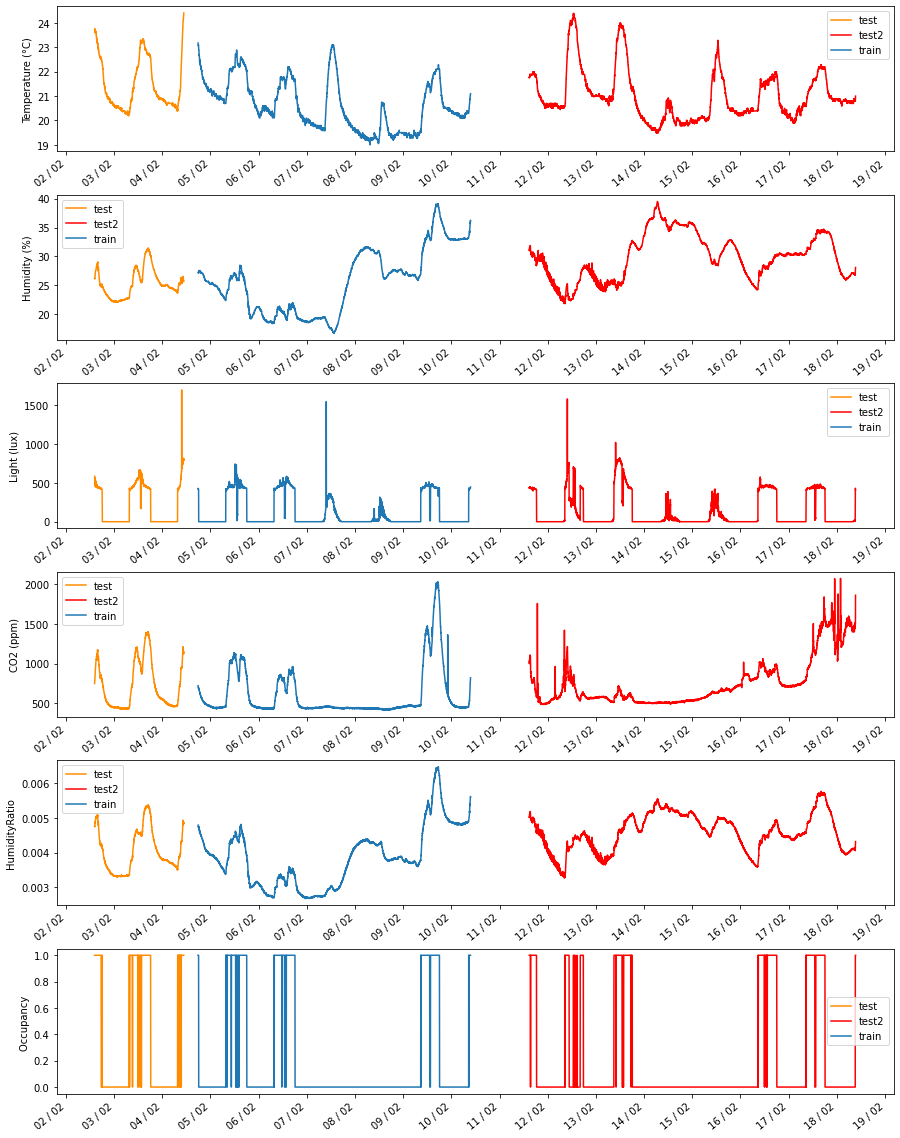

In [ ]:
f, _ = plt.subplots(6,1, figsize=(15, 20))
f.subplots_adjust(hspace=0.3)

for i in range(6):
  ax = plt.subplot(6,1,i+1)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%d / %m'))
  ax.xaxis.set_major_locator(mdates.DayLocator())
  col = input_df.columns[i]
  plt.plot_date(datetime, join1_df[[col]], color='darkorange',label='test', marker='', linestyle='-')
  plt.plot_date(datetime, join2_df[[col]], color='red',label='test2', marker='', linestyle='-')
  plt.plot_date(datetime, join3_df[[col]], label='train', marker='', linestyle='-')
  plt.ylabel(col+' '+units[i])
  plt.legend()
  plt.xticks(ha='right', rotation=40)

We see that we have, for some measures,  almost peaks appearing each day. This is why we are going to choose a 24 hours window size.

> Our goal is to predict occupancy. So we are going to train the input model to get occupancy properly then 

# Preprocessing data

In [ ]:
# Scale the data into [0,1]
scaler = StandardScaler()
input_sc = scaler.fit_transform(input_df)

# Split the data into train and validation sets
n = len(input_sc)
train_sc = input_sc[:int(0.8*n)]
val_sc = input_sc[int(0.8*n):]

# Define the length of the sequences and the batch size
window_size = 10              # length = numbers of rows
batch_size = 60*24              # number of batches, each batch deliver one target

# Create the TimeseriesGenerator objects for the training and test sets
train_gen = keras.preprocessing.sequence.TimeseriesGenerator(train_sc, train_sc, length=window_size, batch_size=batch_size)
val_gen = keras.preprocessing.sequence.TimeseriesGenerator(val_sc, val_sc,length=window_size, batch_size=batch_size)

Since the data has been recorded every minute, and we saw in the plots a periodicity of 24h, we try to predict one day of 24 hours, by putting `batch_size = 24`. We choose the window_size to be 60 minutes.

`TimeseriesGenerator` generates a tuple `(input_windows, targets)`.
* `input_windows` contains batches of `batch_size` consecutive sliding input windows of the train data, with size `length`
* `targets` contains the targets of each window, which means `batch_size` times targets 

In [ ]:
window = train_gen[0][0][3]
pd.DataFrame(np.array(scaler.inverse_transform(window)))

,0,1,2,3,4,5
0,23.150,27.200000,426.0,708.250000,0.004772,1.0
1,23.100,27.200000,426.0,704.500000,0.004757,1.0
2,23.100,27.200000,419.0,701.000000,0.004757,1.0
3,23.100,27.200000,419.0,701.666667,0.004757,1.0
4,23.100,27.200000,419.0,699.000000,0.004757,1.0
5,23.100,27.200000,419.0,689.333333,0.004757,1.0
6,23.075,27.175000,419.0,688.000000,0.004745,1.0
7,23.075,27.150000,419.0,690.250000,0.004741,1.0
8,23.100,27.100000,419.0,691.000000,0.004739,1.0
9,23.100,27.166667,419.0,683.500000,0.004751,1.0


In [ ]:
targets = train_gen[0][1]
pd.DataFrame(np.array(scaler.inverse_transform(targets)))

,0,1,2,3,4,5
0,23.075000,27.150000,419.0,690.250000,0.004741,1.0
1,23.100000,27.100000,419.0,691.000000,0.004739,1.0
2,23.100000,27.166667,419.0,683.500000,0.004751,1.0
3,23.050000,27.150000,419.0,687.500000,0.004734,1.0
4,23.000000,27.125000,419.0,686.000000,0.004715,1.0
...,...,...,...,...,...,...
1435,22.066667,23.926667,433.0,863.000000,0.003925,1.0
1436,22.025000,23.945000,433.0,853.250000,0.003918,1.0
1437,22.000000,23.926667,433.0,858.000000,0.003909,1.0
1438,22.000000,23.890000,433.0,852.500000,0.003903,1.0


# Model

We try to implement the LSTM model. Using multiple LSTM layers can allow the model to learn more complex patterns in the data. The first LSTM layer can learn patterns in the data across time steps, while the second LSTM layer can learn patterns across the sequences output by the first LSTM layer.

Using two LSTM layers can also help to improve the model's performance on the task it is being trained for.

In [ ]:
features = len(train_gen[0][0][0][1])

In [ ]:
model = keras.models.Sequential(name='lstm', layers=[
    layers.LSTM(32, return_sequences=True, input_shape=(window_size, features)),
    layers.LSTM(64),
    layers.Dense(features)
])
model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 32)            4992      
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 30,214
Trainable params: 30,214
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_gen,
    epochs=100,
    callbacks = keras.callbacks.ModelCheckpoint(filepath='./timeseriesmodel.keras', monitor='val_loss', save_best_only=True, mode='min'),
    validation_data=val_gen)

Epoch 1/100
5/5 [==============================] - 5s 400ms/step - loss: 0.7892 - val_loss: 1.8487
Epoch 2/100
5/5 [==============================] - 1s 194ms/step - loss: 0.6070 - val_loss: 1.6078
Epoch 3/100
5/5 [==============================] - 1s 178ms/step - loss: 0.4504 - val_loss: 1.3752
Epoch 4/100
5/5 [==============================] - 1s 175ms/step - loss: 0.3125 - val_loss: 1.1751
Epoch 5/100
5/5 [==============================] - 1s 174ms/step - loss: 0.1938 - val_loss: 1.0212
Epoch 6/100
5/5 [==============================] - 1s 185ms/step - loss: 0.1393 - val_loss: 0.9099
Epoch 7/100
5/5 [==============================] - 1s 178ms/step - loss: 0.1244 - val_loss: 0.8233
Epoch 8/100
5/5 [==============================] - 1s 183ms/step - loss: 0.1120 - val_loss: 0.7769
Epoch 9/100
5/5 [==============================] - 1s 176ms/step - loss: 0.0972 - val_loss: 0.7367
Epoch 10/100
5/5 [==============================] - 1s 198ms/step - loss: 0.0834 - val_loss: 0.7057
Epoch 11/

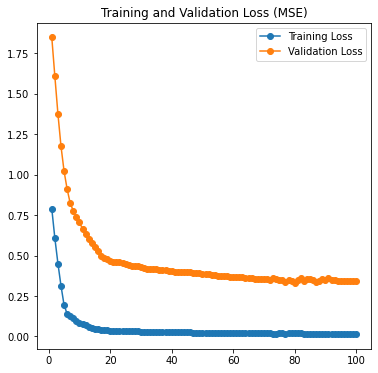

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(6, 6))
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (MSE)')
plt.show()

We observe the loss decreases exponentially.

In [ ]:
model = keras.models.load_model('./timeseriesmodel.keras')


# Testing model predictions

In [ ]:
batch = input_sc[-2*window_size:-window_size].reshape((1, -window_size, features))

In [ ]:
pd.DataFrame(scaler.inverse_transform(model.predict(batch)))

1/1 [==============================] - 1s 1s/step


,0,1,2,3,4,5
0,21.243221,31.865465,389.601105,744.566528,0.004949,0.796466


In [ ]:
pred_list = []
for i in range(batch_size):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]], axis=1)

1/1 [==============================] - 0s 24ms/step


In [ ]:
predict_df = pd.DataFrame(np.append(np.full(input_df[:-batch_size].shape, np.nan), scaler.inverse_transform(pred_list), axis=0), columns=input_df.columns)
predict_df

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
8138,22.303998,28.589261,489.009057,1137.823832,0.004776,0.937636
8139,22.303998,28.589261,489.009103,1137.823869,0.004776,0.937636
8140,22.303998,28.589260,489.009057,1137.823832,0.004776,0.937636
8141,22.303998,28.589261,489.009080,1137.823832,0.004776,0.937636


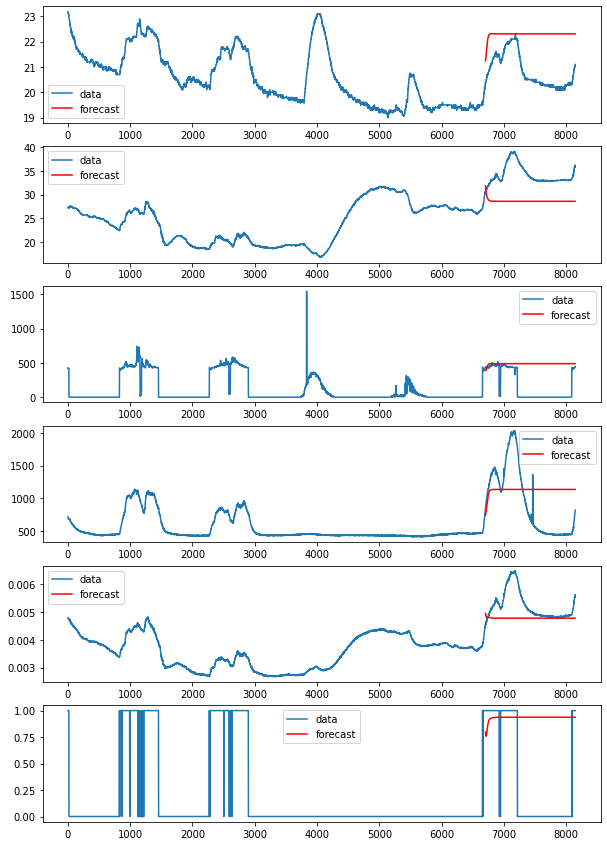

In [ ]:
plt.figure(figsize=(10, 15))
for i in range(6):
  plt.subplot(6,1,i+1)
  col = input_df.columns[i]
  plt.plot(input_df[[col]], label='data')
  plt.plot(predict_df[[col]], color='r',label='forecast')
  plt.legend()

In [ ]:
forecast = [x[0] for x in pred_list]
reals = [x[0] for x in input_df[-batch_size:].to_numpy()]
r2_score(reals, forecast)

-844.003794272918

It seems the model couldn't predict correctly despite the training. After numerous trials we couldn't improve the model no more.